<!--
authors: Matthew Wilson, Daniele Reda
created: 2020/01/14
last_updated: 2020/01/27
-->


## CPSC 533V: Assignment 3 - Tabular Q Learning using OpenAI Gym environments

---

##  Tabular Q-Learning

Tabular Q-learning is an RL algorithm for problems with discrete states and discrete actions. The algorithm is described in the class notes, which borrows the summary description from [Section 6.5](http://incompleteideas.net/book/RLbook2018.pdf#page=153) of Richard Sutton's RL book. In the tabular approach, the Q-value is represented as a lookup table. As discussed in class, Q-learning can further be extended to continuous states and discrete actions, leading to the [Atari DQN](https://arxiv.org/abs/1312.5602) / Deep Q-learning algorithm.  However, it is important and informative to first fully understand tabular Q-learning.

Informally, Q-learning works as follows: The goal is to the perfectly learn the optimal Q-function: 
`Q(s,a)`, which is the *value* of being at state `s` and taking action `a`.  Q tells you how well you expect to do, on average, from here on out, given that you act optimally.  Once the Q function is learned, choosing an optimal action is as simple as looping over all possible actions and choosing the one with the highest Q (optimal action $a^* = \text{max}_a Q(s,a)$).  To learn Q, we initialize it arbitrarily and then iteratively refine it using the Bellman backup equation for Q functions, namely: 
$Q(s,a) \leftarrow Q(s,a) + \alpha [r + \gamma \text{max}_a Q(s', a) - Q(s,a)]$.
Here, $r$ is the reward associated with with the transition from state s to s', and $\alpha$ is a learning rate.

In this assignment you will implement tabular Q-learning and apply it to CartPole -- an environment with a **continuous** state space.  To apply the tabular method, you will need to discretize the CartPole state space by dividing the state-space into bins.


**Assignment goals:**
- to become familiar with python/numpy, as well as using an OpenAI Gym environment
- to understand tabular Q-learning, by implementing tabular Q-Learning for 
  a discretized version of a continuous-state environment, and experimenting with the implementation
- (optional) to develop further intuition regarding possible variations of the algorithm

## Introduction
Deep reinforcement learning has generated impressive results for board games ([Go][go], [Chess/Shogi][chess]), video games ([Atari][atari], , [DOTA2][dota], [StarCraft II][scii]), [and][baoding] [robotic][rubix] [control][anymal] ([of][cassie] [course][mimic] ;)).  RL is beginning to work for an increasing range of tasks and capabilities.  At the same time, there are many [gaping holes][irpan] and [difficulties][amid] in applying these methods. Understanding deep RL is important if you wish to have a good grasp of the modern landscape of control methods.

These next several assignments are designed to get you started with deep reinforcement learning, to give you a more close and personal understanding of the methods, and to provide you with a good starting point from which you can branch out into topics of interest. You will implement basic versions of some of the important fundamental algorithms in this space, including Q-learning and policy gradient/search methods.

We will only have time to cover a subset of methods and ideas in this space.
If you want to dig deeper, we suggest following the links given on the course webpage.  Additionally we draw special attention to the [Sutton book](http://incompleteideas.net/book/RLbook2018.pdf) for RL fundamentals and in depth coverage, and OpenAI's [Spinning Up resources](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html) for a concise intro to RL and deep RL concepts, as well as good comparisons and implementations of modern deep RL algorithms.


[atari]: https://arxiv.org/abs/1312.5602
[go]: https://deepmind.com/research/case-studies/alphago-the-story-so-far
[chess]:https://deepmind.com/blog/article/alphazero-shedding-new-light-grand-games-chess-shogi-and-go 
[dota]: https://openai.com/blog/openai-five/
[scii]: https://deepmind.com/blog/article/AlphaStar-Grandmaster-level-in-StarCraft-II-using-multi-agent-reinforcement-learning
[baoding]: https://bair.berkeley.edu/blog/2019/09/30/deep-dynamics/
[rubix]: https://openai.com/blog/solving-rubiks-cube/
[cassie]: https://www.cs.ubc.ca/~van/papers/2019-CORL-cassie/index.html
[mimic]: https://www.cs.ubc.ca/~van/papers/2018-TOG-deepMimic/index.html
[anymal]: https://arxiv.org/abs/1901.08652


[irpan]: https://www.alexirpan.com/2018/02/14/rl-hard.html
[amid]: http://amid.fish/reproducing-deep-rl



In [1]:
import time
import itertools
import numpy as np
import gym

from tqdm.notebook import tqdm as progress
import matplotlib.pyplot as plt

Two more added minor stylistic cells, turns off notebook scrolling and makes large figures by default:

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
plt.rcParams['figure.figsize'] = [16, 10]

---

## 1. Explore the CartPole environment [18 pts]

Your first task is to familiarize yourself with the OpenAI gym interface and the [CartPole environment]( https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)
by writing a simple hand-coded policy to try to solve it.  
To begin understanding OpenAI Gym environments, [read this first](https://gym.openai.com/docs/).) 
The gym interface is very popular and you will see many algorithm implementations and 
custom environments that support it.  You may even want to use the API in your course projects, 
to define a custom environment for a task you want to solve.

Below is some example code that runs a simple random policy.  You are to:
- **run the code to see what it does**
- **write code that chooses an action based on the observation**.  You will need to learn about the gym API and to read the CartPole documentation to figure out what the `action` and `obs` vectors mean for this environment. 
Your hand-coded policy can be arbitrary, and it should ideally do better than the random policy.  There is no single correct answer. The goal is to become familiar with `env`s.
- **write code to print out the total reward gained by your policy in a single episode run**
- **answer the short-response questions below** (see the TODOs for all of this)

In [4]:
env = gym.make('CartPole-v1')  # you can also try LunarLander-v2, but make sure to change it back
print('observation space:', env.observation_space)
print('action space:', env.action_space)

# To find out what the observations mean, read the CartPole documentation.
# Uncomment the lines below, or visit the source file: 
# https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

cartpole = env.unwrapped
# cartpole?

C:\Users\Haaslab\Miniconda3\envs\pynt\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


observation space: Box(4,)
action space: Discrete(2)


In [5]:
# 1.1 [10pts]

# Random action:
def randomPick(env, state):
    return env.action_space.sample() # random action

# Go left if pole is tilting left, otherwise go right:
def simplePick(env, state):
    theta = state[2]
    return 0 if theta < 0 else 1

# Single run using a policy, return the reward
def runOnce(policyFunc, drawTime=None, updateFunc=None):
    obs = env.reset()
    rewardSum, done = 0, False
    
    # Keep going until the simulation is over:
    while not done:
        lastObs = obs
        action = policyFunc(env, obs)
        obs, reward, done, info = env.step(action)
        rewardSum += reward
        
        # Used later for Q-learning
        if updateFunc is not None:
            updateFunc(lastObs, action, reward, obs)

        if drawTime is not None:
            env.render()
            time.sleep(drawTime)
            
    return rewardSum

# Average reward for a policy, by running multiple times
def getAverageReward(policyFunc, nRuns, drawTime=None, updateFunc=None):
    if drawTime is not None:
        assert nRuns < 50 # Takes too long...
        
    allRewards = np.zeros(nRuns)
    for i in progress(range(nRuns), leave=False):
        allRewards[i] = runOnce(policyFunc, drawTime, updateFunc)
    # env.close()
    return np.mean(allRewards)

# Find average rewards for random and simple policies:
print ("Random pick, av reward: %.4f" % getAverageReward(randomPick, nRuns=1000))
print ("Simple pick, av reward: %.4f" % getAverageReward(simplePick, nRuns=1000))

Random pick, av reward: 22.1480


Simple pick, av reward: 41.8960


To answer the questions below, look at the full [source code here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) if you haven't already.


**1.2. [2pts] Describe the observation and action spaces of CartPole.  What do each of the values mean/do?**

The overservation space has four dimensions:

1. Position (x) of the cart
1. Velocity (v) = dx/dt
1. Angle of the pole (θ), in radians from upright
1. Angular velocity of the pole (ω) = dθ/dt

The action space is a discrete space with two options (i.e. equivalent to boolean):  
either applying a force leftwards or rightwards to the cart. Applying no force is not an option.

**1.3. [2pts] What distribution is used to sample initial states? (see the `reset` function)** 

All four values are picked at random, uniformly from -0.05 to 0.05

**1.4. [2pts] What is the termination condition, which determines if the `env` is `done`?** 

Either the cart has moved too far ($|x| > 2.4$) or the pole has dipped too far ($|\theta| > 12^o$), or if neither, then stops after 200 steps.

**1.5. [2pts] Briefly describe your policy.  What observation information does it use?  What score did you achieve (rough maximum and average)?  And how does it compare to the random policy?**

My policy: If the pole is tilting left ($\theta < 0), then move left, otherwise move right.
On average it scores ~42, rather than ~22 for the random policy

---

## 2. Discretize the env [32 pts]

Next, we need to discretize CartPole's continuous state space to work for tabular Q-learning.  While this is in part  a contrived usage of tabular methods, given the existence of other approaches that are designed to cope with continuous state-spaces, it is also interesting to consider whether tabular methods can be adapted more directly via discretization of the state into bins. Furthermore, tabular methods are simple, interpretabile, and can be proved to converge, and thus they still remain relevant.

Your task is to discretize the state/observation space so that it is compatible with tabular Q-learning.  To do this:
- **implement `obs_normalizer` to pass its test**
- **implement `get_bins` to pass its test**
- **then answer question 2.3**

[map]: https://arxiv.org/abs/1504.04909
[qd]: https://quality-diversity.github.io/

### Distribution of observed states
To assist in discretization, we can first apply random walks through the states and plot how often we end up observing each state dimension values.

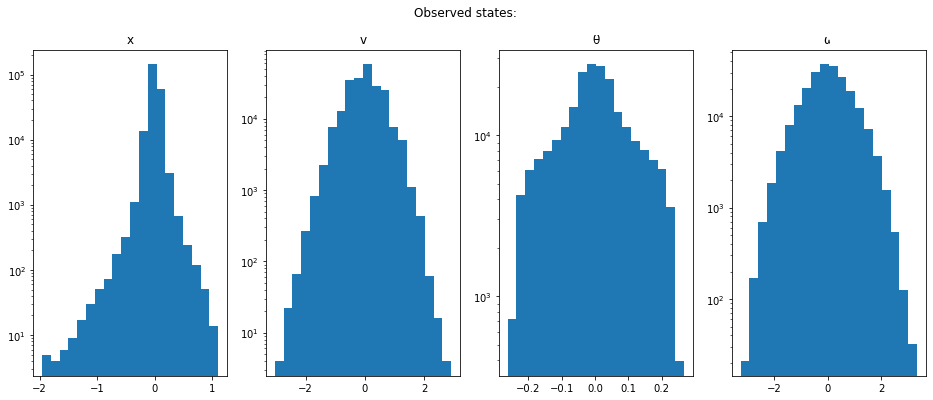

Mins:  [-1.96317684 -3.03328444 -0.26226744 -3.26849353]
Maxs:  [1.11189671 2.89930537 0.26734331 3.33472548]


In [6]:
# Given a history of observed states, plot historgrams for what values were observed along each dimension
def _viewStatesHist(obsStates, nBins):
    f, axes = plt.subplots(1, 4, figsize=(16, 6))
    f.suptitle("Observed states:")
    for i, (ax, title) in enumerate(zip(axes, ["x", "v", "θ", "ω"])):
        ax.hist(obsStates[:, i], log=True, bins=nBins)
        ax.set_title(title)
    plt.show()
    # Also print min & max values, to calculate ranges:
    print ("Mins: ", np.min(obsStates, axis=0))
    print ("Maxs: ", np.max(obsStates, axis=0))

def viewVisitedStates(nRuns):
    _visitedStates = []
    def collectStates(s_old, a, r, s_new):
        _visitedStates.append(s_new)
    
    getAverageReward(randomPick, nRuns, updateFunc=collectStates)
    _viewStatesHist(np.array(_visitedStates), nBins=20)
    
viewVisitedStates(10000)

In [7]:
# Limits to the values accepted, anything outside is put to the outer bin.
# See above for calculations
LIMITS = (1.1, 2.5, 0.25, 3)

# Optional non-linear transform, should be odd (i.e. f(x) = -f(-x), f(0) = 0)
def xTransform(x):
    return x
    #return 1 / (1 + np.exp(-x))
    #return np.cbrt(np.cbrt(x))

def normToRange(v, limit):
    if v <= -limit:
        return 0
    if v >= limit:
        return 1

    # Want: 
    # -limit -> 0
    #   0    -> 0.5
    # limit  -> 1
    limTrans = xTransform(limit)
    vTrans = xTransform(v)
    assert np.abs(vTrans) <= np.abs(limTrans)
    vTrans /= limTrans # -1 <= vTrans <= 1
    return (vTrans + 1) / 2 # 0 <= return <= 1
    
# 2.1 [15pts for passing test_normed]
def obs_normalizer(obs):
    """Normalize the observations between 0 and 1
    
    If the observation has extremely large bounds, then clip to a reasonable range before normalizing; 
    (-2,2) should work.  (It is ok if the solution is specific to CartPole)
    
    Args:
        obs (np.ndarray): shape (4,) containing an observation from CartPole using the bound of the env
    Returns:
        normed (np.ndarray): shape (4,) where all elements are roughly uniformly mapped to the range [0, 1]
    
    """
    normed = np.zeros(obs.shape)
    for i in range(len(obs)):
        normed[i] = normToRange(obs[i], LIMITS[i])
    return normed

In [8]:
### TEST 2.1
def test_normed():
    obs = env.reset()
    while True:
        obs, _, done, _ =  env.step(env.action_space.sample())
        normed = obs_normalizer(obs) 
        assert np.all(normed >= 0.0) and np.all(normed <= 1.0), '{} are outside of (0,1)'.format(normed)
        if done: break
    env.close()
    print('Passed!')
test_normed()

Passed!


In [9]:
# 2.2 [15pts for passing test_binned]
def get_bins(normed, num_bins):
    """Map normalized observations (0,1) to bin index values (0,num_bins-1)
    
    Args:
        normed (np.ndarray): shape (4,) output from obs_normalizer
        num_bins (int): how many bins to use
    Returns:
        binned (np.ndarray): shape (4,) where all elements are values in range [0,num_bins-1]
    
    """
    bins = np.zeros(normed.shape)
    
    # normToRange assumes that the outermost bins will correspond to 0 and 1 respectively
    bins[normed == 0] = 0
    bins[normed == 1] = num_bins-1
    
    # For everything else, map (0, 1) => [1, num_bins - 2] uniformly
    other = (0 < normed) & (normed < 1)
    bins[other] = np.floor(normed[other] * (num_bins - 2)) + 1
    return bins.astype(int) # These are indexes, to force integers

In [10]:
### TEST 2.2
obs = env.reset()
env.close()

def test_binned(num_bins):
    normed = np.array([0.0, 0.2, 0.8, 1.0])
    binned = get_bins(normed, num_bins)
    assert np.all(binned >= 0) and np.all(binned < num_bins), '{} supposed to be between (0, {})'.format(binned, num_bins-1)
    
test_binned(5)
test_binned(10)
test_binned(50)
print('Passed!')

Passed!


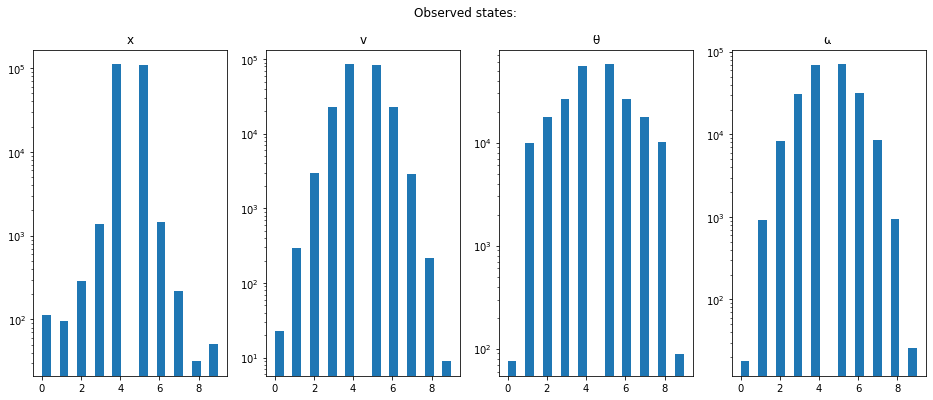

Mins:  [0 0 0 0]
Maxs:  [9 9 9 9]


In [11]:
## Finally, check that the binning still visits all bins too:
def _viewBinsHist(obsBins, nBins):
    f, axes = plt.subplots(1, 4, figsize=(16, 6))
    f.suptitle("Observed bins:")
    for i, (ax, title) in enumerate(zip(axes, ["x", "v", "θ", "ω"])):
        ax.hist(obsBins[:, i], log=True, bins=nBins)
        ax.set_title(title)
    plt.show()    
    print ("Mins: ", np.min(obsBins, axis=0))
    print ("Maxs: ", np.max(obsBins, axis=0))

def viewVisitedBins(nRuns, nBins):
    _visitedBins = []
    def collectStates(s_old, a, r, s_new):
        bins = get_bins(obs_normalizer(s_new), nBins)
        _visitedBins.append(bins)
    
    getAverageReward(randomPick, nRuns, updateFunc=collectStates)
    _viewStatesHist(np.array(_visitedBins), nBins=2*nBins)
    
viewVisitedBins(10000, nBins=10)

**2.3. [2 pts] If your state has 4 values and each is binned into N possible bins, how many bins are needed to represent all unique possible states)?**  (yes, this is an easy question)



Assuming the 'number of bins' means the size of the state space, in this case we require:

$N * N * N * N = N^4$

---

## 3. Solve the env [30pts] 

Using the pseudocode below and the functions you implemented above, implement tabular Q-learning and use it to solve CartPole.

We provide setup code to initialize the Q-table and give examples of interfacing with it. Write the inner and outer loops to train your algorithm.  These training loops will be similar to those deep RL approaches, so get used to writing them!

The algorithm (excerpted from Section 6.5 of [Sutton's book](http://incompleteideas.net/book/RLbook2018.pdf)) is given below:

![Sutton RL](https://i.imgur.com/mdcWVRL.png)

in summary:
- **implement Q-learning using this pseudocode and the helper code**
- **answer the questions below**
- **run the suggested experiments and otherwise experiment with whatever interests you**

In [12]:
# 3.1 [30 pts]

# TODO: implement Q learning, following the pseudo-code above. 
#     - you can follow it almost exactly, but translating things for the gym api and our code used above
#     - make sure to use e-greedy, where e = random about 0.05 percent of the time
#     - make sure to do the S <-- S' step because it can be easy to forget
#     - every log_n steps, you should render your environment and
#       print out the average total episode rewards of the past log_n runs to monitor how your agent trains
#      (your implementation should be able to break at least +150 average reward value, and you can use that 
#       as a breaking condition.  It make take several minutes to run depending on your computer.)

# NOTE: the setup that was originally here mostly got moved to parameters that can be played with.

# Convert (S, A) to a tuple for indexing into Q
def saTuple(s, a):
    return tuple(s) + (a,)

# Initialize Q pulling uniformly from [0, 0.2], and setting boundary to 0.
def buildQ(num_bins):
    qShape = [num_bins]*len(obs)+[env.action_space.n]
    Q = np.random.uniform(low=0, high=0.2, size=qShape)
    # Boundary bins:
    Q[ 0,  :,  :,  :, 0] = 0
    Q[ 0,  :,  :,  :, 1] = 0
    Q[-1,  :,  :,  :, 0] = 0
    Q[-1,  :,  :,  :, 1] = 0
    Q[ :,  0,  :,  :, 0] = 0
    Q[ :,  0,  :,  :, 1] = 0
    Q[ :, -1,  :,  :, 0] = 0
    Q[ :, -1,  :,  :, 1] = 0
    Q[ :,  :,  0,  :, 0] = 0
    Q[ :,  :,  0,  :, 1] = 0
    Q[ :,  :, -1,  :, 0] = 0
    Q[ :,  :, -1,  :, 1] = 0
    Q[ :,  :,  :,  0, 0] = 0
    Q[ :,  :,  :,  0, 1] = 0
    Q[ :,  :,  :, -1, 0] = 0
    Q[ :,  :,  :, -1, 1] = 0
    return Q

# Return reward history, final Q function, and number of runs from a Q learning algorithm until it reaches a certain score.
def getAverageQReward(num_bins=10, alpha=0.1, gamma=0.99, eps=0.05, log_n=500, initQ=None, stopAtScore=None, maxRuns=10000, verbose=True):
    """
    Args:
        num_bins: Number of bins to discretize the state to
        alpha: learning rate, [0, 1]
        gamma: temporal discounting scale
        log_n: how often to display the environment and log scores
        eps: how often to move randomly (vs greedily)
        nRuns: how many runs to make
        initQ: initial Q values, if provided
        
    """
    # set eps to None for purely greedy
    Q = initQ if initQ is not None else buildQ(num_bins)
    obs2bin = lambda obs: tuple(get_bins(obs_normalizer(obs), num_bins=num_bins))
    
    # action = optimal if np.random.rand() > eps else random
    def epsGreedyPickFunc(env, lastObs):
        # random pick:
        if eps is not None and np.random.random() <= eps:
            return randomPick(env, lastObs)
        # otherwise, best:
        else:
            bins = obs2bin(lastObs)
            q0 = Q[saTuple(bins, 0)]
            q1 = Q[saTuple(bins, 1)]
            return 0 if q0 >= q1 else 1

    # Update Q
    def qUpdate(s_old, a, r, s_new):
        b_old, b_new = obs2bin(s_old), obs2bin(s_new)
        t_old = saTuple(b_old, a)

        maxQnew = max(Q[saTuple(b_new, 0)], Q[saTuple(b_new, 1)])
        Q[t_old] += alpha * (r + gamma * maxQnew - Q[t_old])        

    # Keep going until we reach a target score, logging every so often for progress
    avLastReward, atRun = 0, 0
    lastRewardHist = []
    while avLastReward < stopAtScore and atRun < maxRuns:
        avLastReward = getAverageReward(epsGreedyPickFunc, nRuns=log_n, updateFunc=qUpdate)
        lastRewardHist.append(avLastReward)
        if verbose:
            print ("Av reward, runs %d to %d: %.2f" % (atRun, atRun + log_n - 1, avLastReward))
        atRun += log_n
        
    return lastRewardHist, Q, atRun

Av reward, runs 0 to 499: 29.25


Av reward, runs 500 to 999: 28.18


Av reward, runs 1000 to 1499: 47.71


Av reward, runs 1500 to 1999: 69.86


Av reward, runs 2000 to 2499: 91.38


Av reward, runs 2500 to 2999: 91.75


Av reward, runs 3000 to 3499: 102.36


Av reward, runs 3500 to 3999: 102.51


Av reward, runs 4000 to 4499: 102.96


Av reward, runs 4500 to 4999: 118.09


Av reward, runs 5000 to 5499: 121.38


Av reward, runs 5500 to 5999: 114.59


Av reward, runs 6000 to 6499: 116.47


Av reward, runs 6500 to 6999: 117.32


Av reward, runs 7000 to 7499: 117.86


Av reward, runs 7500 to 7999: 126.15


Av reward, runs 8000 to 8499: 104.73


Av reward, runs 8500 to 8999: 120.55


Av reward, runs 9000 to 9499: 117.34


Av reward, runs 9500 to 9999: 119.60


Av reward, runs 10000 to 10499: 132.69


Av reward, runs 10500 to 10999: 118.83


Av reward, runs 11000 to 11499: 133.22


Av reward, runs 11500 to 11999: 133.25


Av reward, runs 12000 to 12499: 130.74


Av reward, runs 12500 to 12999: 117.14


Av reward, runs 13000 to 13499: 125.99


Av reward, runs 13500 to 13999: 110.88


Av reward, runs 14000 to 14499: 146.77


Av reward, runs 14500 to 14999: 140.93


Av reward, runs 15000 to 15499: 139.34


Av reward, runs 15500 to 15999: 184.26
Average score of 184.26 achieved after 16000 runs


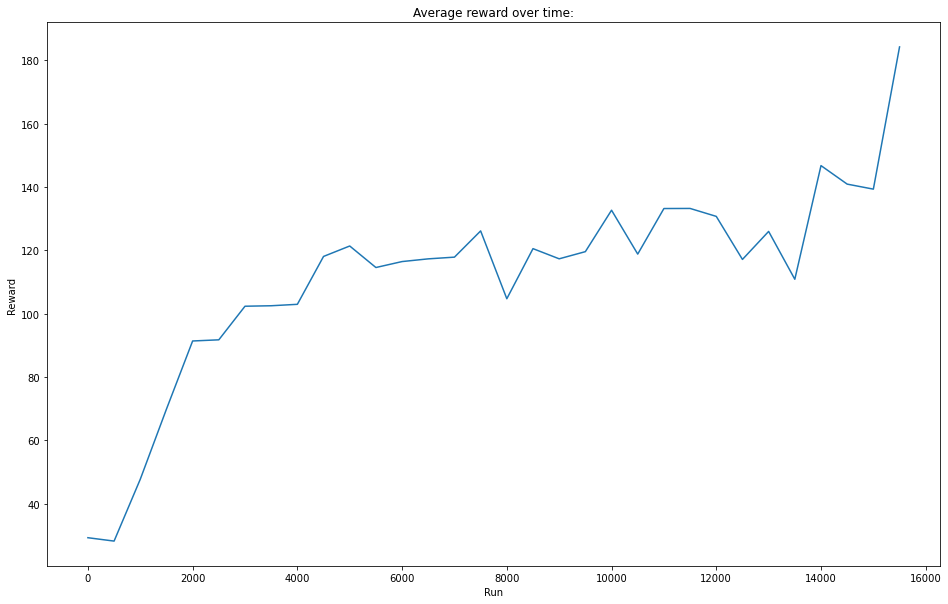

In [13]:
def qLearnUntil150():
    LOG_N, STOP_SCORE = 500, 150
    rewardHistory, _, runCount = getAverageQReward(log_n=LOG_N, stopAtScore=STOP_SCORE, maxRuns=100000)
    print ("Average score of %.2f achieved after %d runs" % (rewardHistory[-1], runCount))

    f, ax = plt.subplots(1, 1)
    ax.plot(np.arange(len(rewardHistory)) * LOG_N, rewardHistory)
    ax.set_title("Average reward over time:")
    ax.set_xlabel("Run")
    ax.set_ylabel("Reward")
    plt.show()

qLearnUntil150()

## 4. Experiments [20 pts]

Given a working algorithm, you will run a few experiments.  Either make a copy of your code above to modify, or make the modifications in a way that they can be commented out or switched between (with boolean flag if statements).

**4.2. [10pts] $\epsilon$-greedy.**  How sensitive are the results to the value of $\epsilon$?   First, write down your prediction of what would happen if $\epsilon$ is set to various values, including for example [0, 0.05, 0.25, 0.5].


For ε = 0, the algorithm will always be greedy and chose the best option, but be unable to learn due to never exploring the environment, so its average reward will remain low and heavily dependent on the initial Q values.

As ε increases to a small value (e.g. 0.1), the algorithm will explore more and more, improving in learning speed as it keeps usually taking good actions, but also explores neighboring states to learn better choices.

As ε continues to increase however to larger values (e.g. 0.4), the algorithm will explore a lot of the state space, but its actions will be more random, so utilization of the Q values to actually reach ideal performance will diminish. 

Finally, as ε gets high enough (e.g. > 0.7), the algorithm will be too random, and again it will not achieve good rewards.


_Now run the experiment and observe the impact on the algorithm.  Report the results below._

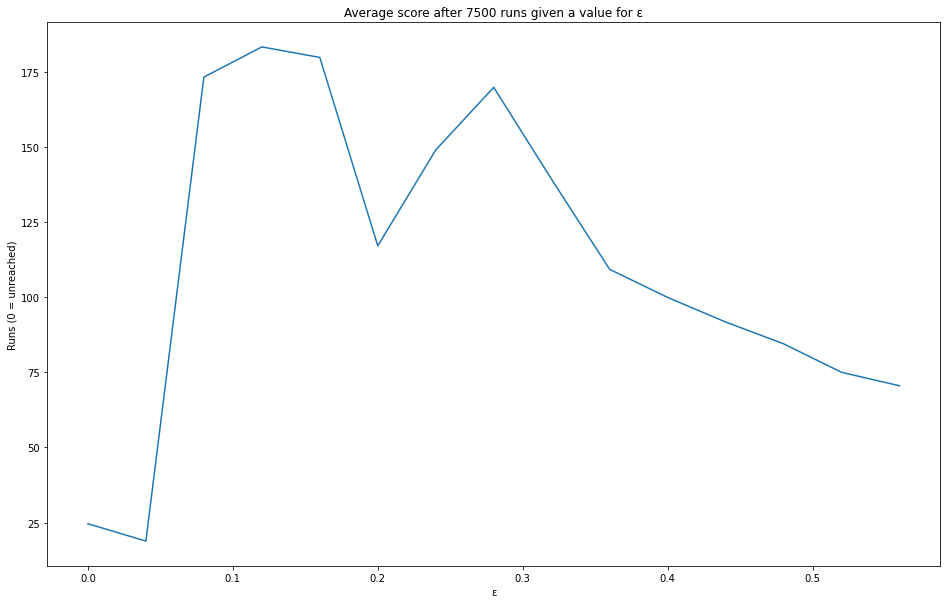

In [21]:
def plotRunCountForEpsilon():
    LOG_N, STOP_SCORE, MAX_RUNS = 500, 100000, 7500 # STOP_SCORE way too high, to force 8k runs

    epsValues = np.arange(0, 0.6, step=0.04)
    avScores = []

    for epsValue in progress(epsValues):
        rewardHist, _, _ = getAverageQReward(
            eps=epsValue,
            log_n=LOG_N, stopAtScore=STOP_SCORE, maxRuns=MAX_RUNS, verbose=False
        )
        avScores.append(rewardHist[-1])

    f, ax = plt.subplots(1, 1)
    ax.plot(epsValues, avScores)
    ax.set_title("Average score after %d runs given a value for ε" % MAX_RUNS)
    ax.set_xlabel("ε")
    ax.set_ylabel("Runs (0 = unreached)")
    plt.show()
    
plotRunCountForEpsilon()    

**4.3. [10pts] Design your own experiment.** Design a modification that you think would either increase or reduce performance.  A simple example (which you can use) is initializing the Q-table differently, and thinking about how this might alter performance. Write down your idea, what you think might happen, and why.

A very simple modification is exploring behaviour for all **pairs** of epsilon and alpha.

Taking a similar approach, we now can iterate over multiple values of each, and see good its score can within a certain number of iterations (2000, to keep execution time under an hour).

As above, we expect similar results: α too low will not learn, as the algorithm won't update much beyond its initial values. α too high will become too random, as its Q will depend too much on what it just observed, so it will have trouble stabilizing.

These two can balance off eachother: lower α increases stability, so will result in the optimal ε being higher to counteract it with more randomization. Similarly, a higher α will have a lower optimal ε. The end result will be a curve of optimal values.

_Run the experiment and report the results._

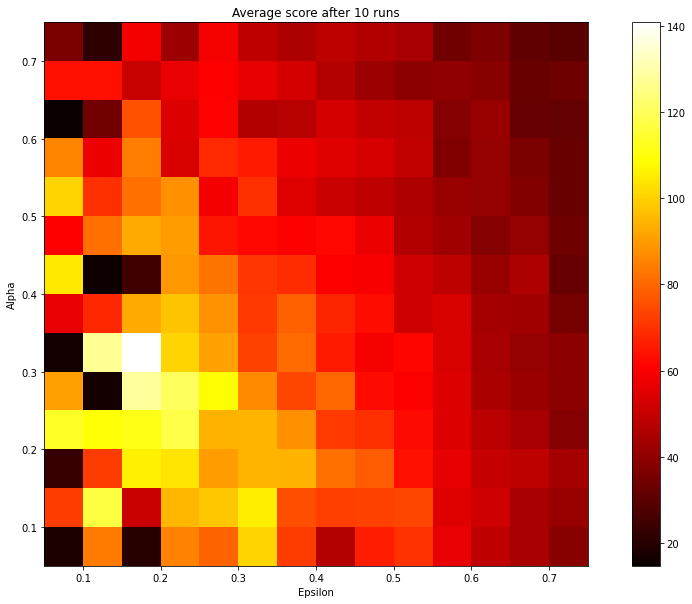

In [16]:
def plotRunCountForEpsilonAndAlpha():
    LOG_N, STOP_SCORE, MAX_RUNS = 200, 100000, 2000 # STOP_SCORE way too high, to force 2k runs
    
    alphaValues = np.arange(0.05, 0.75, step=0.05)
    epsValues = np.arange(0.05, 0.75, step=0.05)
    
    avScores = np.zeros((len(alphaValues), len(epsValues)))
    for i, alphaValue in enumerate(progress(alphaValues)):
        for j, epsValue in enumerate(progress(epsValues, leave=False)):
            rewardHist, _, _ = getAverageQReward(
                alpha=alphaValue, eps=epsValue,
                log_n=LOG_N, stopAtScore=STOP_SCORE, maxRuns=MAX_RUNS, verbose=False
            )
            avScores[i][j] = rewardHist[-1]
    
    f, ax = plt.subplots(1, 1)
    m = ax.imshow(avScores[::-1, :], cmap='hot', interpolation='none', extent=[0.05, 0.75, 0.05, 0.75])
    ax.set_title("Average score after %d runs" % (10))
    ax.set_xlabel("Epsilon")
    ax.set_ylabel("Alpha")
    f.colorbar(m)
    plt.show()

rc = plotRunCountForEpsilonAndAlpha()

In [ ]:
# Train a good option, and visualize it for fun.
def showGoodOptions():
    GOOD_EPS = 0.175
    GOOD_ALPHA = 0.225
    LOG_N = 500
    N_BINS = 10
    rewardHistory, goodQ, _ = getAverageQReward(log_n=LOG_N, stopAtScore=1000, maxRuns=10000)

    # learning improvements:
    f, ax = plt.subplots(1, 1)
    ax.plot(np.arange(len(rewardHistory)) * LOG_N, rewardHistory)
    ax.set_title("Average reward over time:")
    ax.set_xlabel("Run")
    ax.set_ylabel("Reward")
    plt.show()
    
    obs2bin = lambda obs: tuple(get_bins(obs_normalizer(obs), num_bins=N_BINS))
    
    # Run and render:
    def greedyPickGood(env, lastObs):
        # random pick:
        if np.random.random() <= GOOD_EPS:
            return randomPick(env, lastObs)
        # otherwise, best:
        else:
            bins = obs2bin(lastObs)
            q0 = goodQ[saTuple(bins, 0)]
            q1 = goodQ[saTuple(bins, 1)]
            return 0 if q0 >= q1 else 1
    
    runOnce(greedyPickGood, drawTime=0.05, updateFunc=None)    

showGoodOptions()

---

## A. Extensions 

Extensions added:
- histograms for observed states and bins for all state dimensions
- average reward progress plotted for Q learning 
- alternative value transforms added for the state->bin code (but the identity kept for simplicity)

Looking at the observed bins, it's obvious that these aren't very flat (especially for x position), so a good experiment would be to pick quantiles to break them up, based off observations in the random state - i.e. lowest 10% of values into the first bin, next 10% into the next, ... but not implemented due to time constraints

